In [174]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [175]:
import tensorflow as tf
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14394452945513012700
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15785659421892497075
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801326797
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10247167650179277605
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:0a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7782773556
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11794060355689607490
physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:42:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16995623195401472732
physical_device_desc: "device: XLA_GPU device"
, name: "

In [321]:
VIEW_df = pd.read_csv('/home/whsu014/data/Cholesterol_PHH_360dayspy_with_true_values_01day_ethn_coded_PREDICT_Variables_sbp2dbp2.csv')
print(VIEW_df.shape)
print(VIEW_df.columns)

(2099160, 51)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')


In [322]:
VIEW_sub_df = VIEW_df[['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                       'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                       'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                       'ATORVASTATIN', 'SIMVASTATIN', 
                       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL',
                       'TRUE_TCHDL', 'SBP', 'DBP',
                       'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                       'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR']]
print(VIEW_sub_df.shape)
print(VIEW_sub_df.isnull().sum())

(2099160, 33)
STUDENT_INDEX_MASTER          0
DATE                          0
QUARTERS                      0
AGE                           0
ETHNICITY                     0
SEX                           0
NZDEP                         0
TEST                          0
HDL                           0
LDL                           0
TRI                           0
TCL                           0
TCHDL                         0
STATINS                       0
ATORVASTATIN                  0
SIMVASTATIN                   0
TRUE_HDL                      0
TRUE_LDL                      0
TRUE_TRI                      0
TRUE_TCL                      0
TRUE_TCHDL                    0
SBP                           0
DBP                           0
SBP2                          0
DBP2                        112
SMOKING                      28
EN_TCHDL                  23884
HX_DIABETES                   0
FAMILY_HISTORY                0
HX_CVD                        0
GEN_LIPID                 

In [323]:
print("ETHNICITY", VIEW_sub_df.ETHNICITY.unique())
print("SEX", VIEW_sub_df.SEX.unique())
print("NZDEP", VIEW_sub_df.NZDEP.unique())
print("SMOKING", VIEW_sub_df.SMOKING.unique())
print("HX_DIABETES", VIEW_sub_df.HX_DIABETES.unique())
print("FAMILY_HISTORY", VIEW_sub_df.FAMILY_HISTORY.unique())
print("HX_CVD", VIEW_sub_df.HX_CVD.unique())
print("GEN_LIPID", VIEW_sub_df.GEN_LIPID.unique())
print("RENAL", VIEW_sub_df.RENAL.unique())

ETHNICITY ['E' 'A' 'B' 'H' 'C' 'G' 'D' 'F']
SEX ['F' 'M']
NZDEP [4 1 3 5 2]
SMOKING [ 0.  3.  1.  4.  5.  2. nan]
HX_DIABETES [0. 1.]
FAMILY_HISTORY [1. 0.]
HX_CVD [0. 1.]
GEN_LIPID [0. 1. 4. 2. 3.]
RENAL [nan  0.  1.  2.  3.]


In [324]:
# find number of nan in SMOKING and RENAL
print(VIEW_sub_df.SMOKING.isnull().sum())
print(VIEW_sub_df.RENAL.isnull().sum())
print(VIEW_sub_df.HX_DIABETES_YR.isnull().sum())

28
1440208
1417864


In [325]:
# remove individuals that 
# contains nans
print(VIEW_sub_df.shape)
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['DBP2'])]
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['SMOKING'])]
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['EN_TCHDL'])]
print(VIEW_sub_df.shape)

(2099160, 33)
(2075136, 33)


In [326]:
# Count size of ethnicity groups
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'D'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'F'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'G'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H'].shape[0]//28)

3597
44184
6486
1234
7236
50
2333
8992


In [327]:
# Combine D, F and G
VIEW_sub_A_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A']
VIEW_sub_B_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B']
VIEW_sub_C_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C']
VIEW_sub_D_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY.isin(['D', 'F', 'G'])] # MELAA, Other and Other_Asian
VIEW_sub_E_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E']
VIEW_sub_H_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H']
print(VIEW_sub_A_df.shape[0]//28)
print(VIEW_sub_B_df.shape[0]//28)
print(VIEW_sub_C_df.shape[0]//28)
print(VIEW_sub_D_df.shape[0]//28)
print(VIEW_sub_E_df.shape[0]//28)
print(VIEW_sub_H_df.shape[0]//28)

3597
44184
6486
3617
7236
8992


In [328]:
# random sampling unique ID 
# to control ethn imbalance
ethn_A_list = VIEW_sub_A_df.STUDENT_INDEX_MASTER.unique()
ethn_B_list = VIEW_sub_B_df.STUDENT_INDEX_MASTER.unique()
ethn_C_list = VIEW_sub_C_df.STUDENT_INDEX_MASTER.unique()
ethn_D_list = VIEW_sub_D_df.STUDENT_INDEX_MASTER.unique()
ethn_E_list = VIEW_sub_E_df.STUDENT_INDEX_MASTER.unique()
ethn_H_list = VIEW_sub_H_df.STUDENT_INDEX_MASTER.unique()
ethn_A_sample = list(np.random.choice(ethn_A_list, 3333, replace=False))
ethn_B_sample = list(np.random.choice(ethn_B_list, 3335, replace=False)) # over sample Europeans
ethn_C_sample = list(np.random.choice(ethn_C_list, 3333, replace=False)) # to make a data of 
ethn_D_sample = list(np.random.choice(ethn_D_list, 3333, replace=False)) # 20,000 individuals
ethn_E_sample = list(np.random.choice(ethn_E_list, 3333, replace=False))
ethn_H_sample = list(np.random.choice(ethn_H_list, 3333, replace=False))
print(VIEW_sub_df.shape)
ethn_sample = ethn_A_sample + ethn_B_sample + ethn_C_sample + \
              ethn_D_sample + ethn_E_sample + ethn_H_sample
VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.STUDENT_INDEX_MASTER.isin(ethn_sample)]
print(VIEW_sub_df.shape)


(2075136, 33)
(560000, 33)


In [329]:
print(VIEW_sub_df.columns) 
#check ETHN distribution
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "A"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "B"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "C"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "D"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "F"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "G"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "E"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "H"].shape[0])

Index(['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
       'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
       'ATORVASTATIN', 'SIMVASTATIN', 'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI',
       'TRUE_TCL', 'TRUE_TCHDL', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
       'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
       'RENAL', 'HX_DIABETES_YR'],
      dtype='object')
93324
93380
93324
31752
1344
60228
93324
93324


In [330]:
print(VIEW_sub_df.columns)
print(VIEW_sub_df.DATE.iloc[0])
print(VIEW_sub_df.HX_DIABETES_YR.iloc[110])
#print(VIEW_sub_df.isnull().sum())

Index(['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
       'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
       'ATORVASTATIN', 'SIMVASTATIN', 'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI',
       'TRUE_TCL', 'TRUE_TCHDL', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
       'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
       'RENAL', 'HX_DIABETES_YR'],
      dtype='object')
2009-07-01 00:00:00
nan


In [331]:
# encode ID strings to numbers
# create a dictionary to store 
# its mapping 
VIEW_sub_v = VIEW_sub_df.values
ID_to_num = {}
num = 0
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 0] not in ID_to_num:
        ID_to_num[VIEW_sub_v[i, 0]] = num
        num += 1
    VIEW_sub_v[i, 0] = ID_to_num[VIEW_sub_v[i, 0]]
# if ethn is , F or G change to D
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 4] in ['F', 'G']:
        VIEW_sub_v[i, 4] = 'D'
# change date into datetime object 26, 27
for i in range(len(VIEW_sub_v)):
    VIEW_sub_v[i, 1] = datetime.datetime.strptime(VIEW_sub_v[i, 1], '%Y-%m-%d %H:%M:%S')
    # process RENAL values
    # change RENAL [nan  0.  1.  2.  3.]
    # to RENAL [0, 1, 2, 3, 4]
    if np.isnan(VIEW_sub_v[i, 31]):
        VIEW_sub_v[i, 31] = 0
    else:
        VIEW_sub_v[i, 31] = VIEW_sub_v[i, 31] + 1
    # process HX_DIABETES_YR values
    if np.isnan(VIEW_sub_v[i, 32]):
        VIEW_sub_v[i, 32] = 0
    else:
        VIEW_sub_v[i, 32] = VIEW_sub_v[i, 1].year - VIEW_sub_v[i, 32]

In [332]:
print(pd.isnull(VIEW_sub_v).sum())
print(VIEW_sub_v[0:100, 0])
print(VIEW_sub_v[0:100, 3])
print("ETHNICITY VALUES", np.unique(VIEW_sub_v[:, 4]))
print("RENAL VALUES", np.unique(VIEW_sub_v[:, 31]))
print("HX_DIABETES_YR VALUES", np.unique(VIEW_sub_v[:, 32]))
#check distribution of ETHNICITY in the first 5000 individuals
VIEW_sub_sub = VIEW_sub_v[0:(5000*28), :]
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "A"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "B"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "C"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "D"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "E"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "H"].shape[0]//28)

0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[59.0 60.0 60.0 60.0 60.0 61.0 61.0 61.0 61.0 62.0 62.0 62.0 62.0 63.0
 63.0 63.0 63.0 64.0 64.0 64.0 64.0 64.0 65.0 65.0 65.0 65.0 66.0 66.0
 54.0 55.0 55.0 55.0 55.0 56.0 56.0 56.0 56.0 57.0 57.0 57.0 57.0 58.0
 58.0 58.0 58.0 59.0 59.0 59.0 59.0 60.0 60.0 60.0 60.0 61.0 61.0 61.0
 44.0 44.0 44.0 45.0 45.0 45.0 45.0 46.0 46.0 46.0 46.0 47.0 47.0 47.0
 47.0 48.0 48.0 48.0 48.0 49.0 49.0 49.0 49.0 49.0 50.0 50.0 50.0 50.0
 66.0 67.0 67.0 67.0 67.0 68.0 68.0 68.0 68.0 69.0 69.0 69.0 69.0 70.0
 70.0 70.0]
ETHNICITY VALUES ['A' 'B' 'C' 'D' 'E' 'H']
RENAL VALUES [0 1.0 2.0 3.0 4.0]
HX_DIABETES_YR VALUES [0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0
 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0
 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 3

'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
'ATORVASTATIN', 'SIMVASTATIN', 'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI',
'TRUE_TCL', 'TRUE_TCHDL', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
'RENAL', 'HX_DIABETES_YR'

In [333]:
# one hot encode categorical variables
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 5] == 'M':
        VIEW_sub_v[i, 5] = 0
    else:
        VIEW_sub_v[i, 5] = 1
        
ethn_v = np.zeros((len(VIEW_sub_v), 6))
ethn_idx = {'A': 0,
            'B': 1,
            'C': 2,
            'D': 3,
            'E': 4,
            'H': 5}

for i in range(len(VIEW_sub_v)):
    ethn_v[i, ethn_idx[VIEW_sub_v[i, 4]]] = 1

# reorganise columns  
# STUDENT_INDEX_MASTER, QUARTERS, AGE, SEX, NZDEP, 
# A, B, C, D, E, H
# SBP, DBP, SBP2, DBP2,
# SMOKING, EN_TCHDL, HX_DIABETES, FAMILY_HISTORY, HX_CVD, 
# GEN_LIPID, RENAL, HX_DIABETES_YR
# STATINS, ATORVASTATIN, SIMVASTATIN, 
# TEST, HDL, LDL, TRI, TCL, TCHDL
# TRUE_HDL, TRUE_LDL, TRUE_TRI, TRUE_TCL, TRUE_TCHDL
VIEW_sub_v1 = VIEW_sub_v[:, [0,2,3,5,6]] # Demographic variables + QUARTERS
VIEW_sub_v2 = VIEW_sub_v[:, [13,14,15]] # STATINS  PHH
VIEW_sub_v3 = VIEW_sub_v[:, [21,22,23,24,25,26,27,28,29,30,31,32]] # PREDICT variables
VIEW_sub_v4 = VIEW_sub_v[:, [7,8,9,10,11,12]] # INTERPOLATED CHOLESTEROLS TESTSAFE
VIEW_sub_v5 = VIEW_sub_v[:, [16,17,18,19,20]] # TRUE CHOLESTEROLS
VIEW_1hot_encoded_v = np.append(VIEW_sub_v1, ethn_v, axis= 1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v3, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v2, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v4, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v5, \
                                axis=1)
print(VIEW_1hot_encoded_v.shape)

(560000, 37)


 # Reorganised columns
 STUDENT_INDEX_MASTER, QUARTERS, AGE, SEX, NZDEP, 
 A, B, C, D, E, H
 SBP, DBP, SBP2, DBP2,
 SMOKING, EN_TCHDL, HX_DIABETES, FAMILY_HISTORY, HX_CVD, 
 GEN_LIPID, RENAL, HX_DIABETES_YR
 STATINS, ATORVASTATIN, SIMVASTATIN, 
 TEST, HDL, LDL, TRI, TCL, TCHDL
 TRUE_HDL, TRUE_LDL, TRUE_TRI, TRUE_TCL, TRUE_TCHDL

In [334]:
print(np.unique(VIEW_1hot_encoded_v[:, -11]))
print(max(np.unique(VIEW_1hot_encoded_v[:, -11])))
print(min(np.unique(VIEW_1hot_encoded_v[:, -11])))
#print(VIEW_1hot_encoded_v[0:28, -11:])
print(type(VIEW_1hot_encoded_v[0, -10]))

[0 1]
1
0
<class 'float'>


In [335]:
# before normalising
# flatten Cholesterol vectors
# after the last test within
# the first 8 quarters using 
# TRUE cholesterol values

#number_of_inds = #VIEW_1hot_encoded_v.shape[0]//28
#start = 0
#end = 28
missing_a_measure = 0
IDs_of_missing_measure = []
value_indicating_test = max(np.unique(VIEW_1hot_encoded_v[:, -11]))
value_indicating_no_test = min(np.unique(VIEW_1hot_encoded_v[:, -11]))
VIEW_1hot_encoded_test_v = np.empty([0, 37])

start_t = time.time()
for i in range(5200): #number_of_inds
    ind_v = copy.deepcopy(VIEW_1hot_encoded_v[(i*28):((i+1)*28), :])
    test_list = list(ind_v[0:8, -11])
    quarters_v = copy.deepcopy(ind_v[:, 1])
    age_v = copy.deepcopy(ind_v[:, 2])
    idx = len(test_list) - 1 - \
          test_list[::-1].index(value_indicating_test)
    last_v = copy.deepcopy(ind_v[idx, -11:])
    # parse values from TRUE choleterol lists\
    for j in range(1, 6):
        ch_s = last_v[j+5]
        if len(ch_s) > 4:
            ch_list = ch_s[1:-1].split(', ')
            last_v[j] = float(ch_list[-1])
        else:
            missing_a_measure += 1
            IDs_of_missing_measure.append(ind_v[0, 0])
    ind_v[idx, -11:] = last_v
    last_v[0] = value_indicating_no_test #this might be the wrong assumption
    for j in range((idx+1),28):
        ind_v[j, -11:] = last_v
    ind_v[:, 1] = quarters_v
    ind_v[:, 2] = age_v
    VIEW_1hot_encoded_test_v = np.append(VIEW_1hot_encoded_test_v, \
                               ind_v, axis = 0)
end_t = time.time()
print(end_t - start_t)
#print(VIEW_1hot_encoded_test_v[0:28, -11:])   
print(missing_a_measure)
print(len(IDs_of_missing_measure))
print(VIEW_1hot_encoded_v.shape)
print(VIEW_1hot_encoded_test_v.shape)

350.77414178848267
193
193
(560000, 37)
(145600, 37)


In [336]:
print(len(np.unique(IDs_of_missing_measure)))
#print(VIEW_1hot_encoded_test_v[VIEW_1hot_encoded_test_v[:, 0] == 68][:, -11:])
print(len(np.unique(VIEW_1hot_encoded_test_v[:, 0])))
all_IDs_set = set(np.unique(VIEW_1hot_encoded_test_v[:, 0]))
missing_IDs = set(IDs_of_missing_measure)
new_IDs_set = all_IDs_set - missing_IDs
print(len(all_IDs_set))
print(len(missing_IDs))
print(type(new_IDs_set))
print(len(new_IDs_set))
print(type(list(new_IDs_set)))
print(len(list(new_IDs_set)))
new_IDs_list = list(new_IDs_set)
VIEW_1hot_encoded_test_v = VIEW_1hot_encoded_test_v[np.isin(VIEW_1hot_encoded_test_v[:, 0], \
                                                            new_IDs_list)]
VIEW_1hot_encoded_v = VIEW_1hot_encoded_v[np.isin(VIEW_1hot_encoded_v[:, 0], \
                                                            new_IDs_list)]
print(VIEW_1hot_encoded_v.shape)
print(VIEW_1hot_encoded_test_v.shape)

138
5200
5200
138
<class 'set'>
5062
<class 'list'>
5062
(141736, 37)
(141736, 37)


In [346]:
VIEW_1hot_encoded_wout_true_v = copy.deepcopy(VIEW_1hot_encoded_v[:, :-5])
VIEW_1hot_encoded_test_wout_true_v = copy.deepcopy(VIEW_1hot_encoded_test_v[:, :-5])
print(VIEW_1hot_encoded_wout_true_v.shape)
print(VIEW_1hot_encoded_test_wout_true_v.shape)
###################################
# log transform cholesterol values
###################################
#print(np.around(VIEW_1hot_encoded_wout_true_v[0:25, -5:].astype(np.double), decimals=2))

#VIEW_1hot_encoded_wout_true_v[:, -5:] = np.log(VIEW_1hot_encoded_wout_true_v[:, -5:].astype(np.double))
#VIEW_1hot_encoded_test_wout_true_v[:, -5:] = np.log(VIEW_1hot_encoded_test_wout_true_v[:, -5:].astype(np.double))

#print(np.around(VIEW_1hot_encoded_wout_true_v[0:25, -5:].astype(np.double), decimals=2))
#VIEW_1hot_encoded_wout_true_v = np.exp(VIEW_1hot_encoded_wout_true_v[:, -5:].astype(np.double))
#print(np.around(VIEW_1hot_encoded_wout_true_v[0:25, -5:].astype(np.double), decimals=2))
print(VIEW_1hot_encoded_wout_true_v.shape)
print(VIEW_1hot_encoded_test_wout_true_v.shape)

(141736, 32)
(141736, 32)
(141736, 32)
(141736, 32)


In [347]:
# normalise vectors to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(VIEW_1hot_encoded_wout_true_v)
scaled_test = scaler.transform(VIEW_1hot_encoded_test_wout_true_v)
#decided to use standardise instead of normalise
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
#scaler = StandardScaler()
#scaled_train = scaler.fit_transform(VIEW_1hot_encoded_wout_true_v)
#scaled_test = scaler.transform(VIEW_1hot_encoded_test_wout_true_v)
#print(np.around(VIEW_1hot_encoded_wout_true_v[0:28, -5:].astype(np.double), decimals=2))
#print(np.around(scaled_train[0:28, -5:].astype(np.double), decimals=2))
#inv_data = scaler.inverse_transform(scaled_train)
#print(np.around(inv_data[0:28, -5:].astype(np.double), decimals=2))

#print("TEST VALUES", np.unique(scaled_train[:, -6]))
#print("Value indicating test", max(np.unique(scaled_train[:, -6])))

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f132c5ffc18>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


(array([2.0000e+00, 7.5000e+01, 5.0500e+02, 1.5180e+03, 3.7120e+03,
        6.3150e+03, 9.7680e+03, 1.1577e+04, 1.3351e+04, 1.3144e+04,
        1.3786e+04, 1.2323e+04, 1.1021e+04, 9.9280e+03, 8.0640e+03,
        6.9590e+03, 5.5020e+03, 4.3150e+03, 2.9550e+03, 2.1130e+03,
        1.4770e+03, 1.0590e+03, 7.0400e+02, 4.8200e+02, 3.2200e+02,
        2.4700e+02, 1.3100e+02, 1.2100e+02, 6.7000e+01, 4.9000e+01,
        3.4000e+01, 2.0000e+01, 1.9000e+01, 1.6000e+01, 1.1000e+01,
        7.0000e+00, 7.0000e+00, 6.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

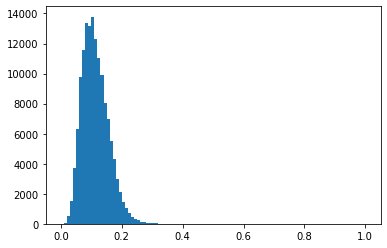

In [348]:
#pyplot.hist(VIEW_1hot_encoded_v[:, -1], bins= 100)
pyplot.hist(scaled_train[:, -1], bins= 100)

In [165]:
# Create test data array
# ensuring test does not 
# look foreward beyond 
# last test in the initial
# 8 quarters
'''
number_of_inds = 5000#VIEW_1hot_encoded_v.shape[0]//28
start = 0
end = 28
value_indicating_test = max(np.unique(scaled_train[:, -6]))
value_indicating_no_test = min(np.unique(scaled_train[:, -6]))
scaled_test = np.empty([0, 32])
for i in range(number_of_inds):
    ind_v = copy.deepcopy(scaled_train[start:end, :])
    test_list = list(ind_v[0:8, -6])
    quarters_v = copy.deepcopy(ind_v[:, 1])
    age_v = copy.deepcopy(ind_v[:, 2])
    idx = len(test_list) - 1 - \
          test_list[::-1].index(value_indicating_test)
    last_v = copy.deepcopy(ind_v[idx, -6:])
    last_v[0] = value_indicating_no_test #this might be the wrong assumption
    for j in range((idx+1),28):
        ind_v[j, -6:] = last_v
        #ind_v[j, -6] = 0  # set TEST to 0
    ind_v[:, 1] = quarters_v
    ind_v[:, 2] = age_v
    scaled_test = np.append(scaled_test, \
                            ind_v, axis = 0)
    start = end
    end += 28
print(scaled_train.shape)
print(scaled_test.shape)
#VIEW_1hot_encoded_v = VIEW_1hot_encoded_v[0:(number_of_inds*28), :]
#print(VIEW_1hot_encoded_v.shape)
#print(VIEW_1hot_encoded_test_v.shape)
'''

(560000, 32)
(140000, 32)


In [284]:
#inspect inds
ind = 1
print(np.around(VIEW_1hot_encoded_v[0:28, -10:-5].astype(np.double), decimals=2))
print(np.around(np.exp(VIEW_1hot_encoded_wout_true_v[0:28, -5:].astype(np.double)), decimals=2))
#print(np.around(scaled_test[(ind*28):((ind+1)*28)+1, -9:], 2))
#inversed_log_data = np.exp(scaled_test[(ind*28):((ind+1)*28)+1, -5:])
#print(np.around())

[[1.58 4.07 2.34 6.79 4.34]
 [1.52 3.88 2.31 6.52 4.31]
 [1.5  3.5  2.13 6.03 4.04]
 [1.5  2.98 1.84 5.38 3.58]
 [1.5  2.46 1.55 4.73 3.13]
 [1.48 2.41 1.48 4.61 3.1 ]
 [1.45 2.84 1.65 5.04 3.49]
 [1.42 3.26 1.81 5.46 3.88]
 [1.19 3.26 1.5  5.09 4.34]
 [0.95 2.99 0.93 4.37 4.62]
 [1.14 3.26 1.04 4.88 4.38]
 [1.33 3.53 1.14 5.39 4.14]
 [1.43 3.74 1.4  5.82 4.11]
 [1.41 3.84 1.91 6.13 4.39]
 [1.39 3.95 2.43 6.44 4.67]
 [1.37 4.05 2.94 6.74 4.96]
 [1.36 4.1  3.14 6.87 5.09]
 [1.35 4.11 3.02 6.82 5.08]
 [1.34 4.12 2.89 6.76 5.06]
 [1.34 4.13 2.77 6.71 5.05]
 [1.33 4.13 2.64 6.66 5.03]
 [1.32 4.14 2.52 6.6  5.01]
 [1.31 4.15 2.39 6.55 5.  ]
 [1.31 4.16 2.27 6.49 4.98]
 [1.3  4.17 2.15 6.44 4.97]
 [1.29 4.17 2.02 6.38 4.95]
 [1.29 4.18 1.9  6.33 4.94]
 [1.28 4.19 1.77 6.28 4.92]]
[[1.58 4.07 2.34 6.79 4.34]
 [1.52 3.88 2.31 6.52 4.31]
 [1.5  3.5  2.13 6.03 4.04]
 [1.5  2.98 1.84 5.38 3.58]
 [1.5  2.46 1.55 4.73 3.13]
 [1.48 2.41 1.48 4.61 3.1 ]
 [1.45 2.84 1.65 5.04 3.49]
 [1.42 3.26 1.81 5.

In [145]:
#STUDENT_INDEX_MASTER, QUARTERS, AGE, SEX, NZDEP, 
# A, B, C, D, E, H (10)
# SBP, DBP, SBP2, DBP2,
# SMOKING, EN_TCHDL, HX_DIABETES, FAMILY_HISTORY, HX_CVD, 
# GEN_LIPID, RENAL, HX_DIABETES_YR
# STATINS, ATORVASTATIN, SIMVASTATIN, 
# TEST, HDL, LDL, TRI, TCL, TCHDL
#VIEW_1hot_encoded_non_sparse_v = VIEW_1hot_encoded_v[:, [0,1,2,3,4,5,6,\
#                                                         7,8,9,10,11,12,\
#                                                         13,14,15,16,23,\
#                                                         24,25,26,27,28,\
#                                                         29,30,31]]
#VIEW_1hot_encoded_test_non_sparse_v = VIEW_1hot_encoded_test_v[:, [0,1,2,3,4,5,6,\
#                                                         7,8,9,10,11,12,\
#                                                         13,14,15,16,23,\
#                                                         24,25,26,27,28,\
#                                                         29,30,31]]
#print(VIEW_1hot_encoded_v.shape)
#print(VIEW_1hot_encoded_non_sparse_v.shape)
#print(VIEW_1hot_encoded_test_v.shape)
#print(VIEW_1hot_encoded_test_non_sparse_v.shape)

(560000, 32)
(560000, 26)
(560000, 32)
(560000, 26)


In [349]:
###############################################
# set up data for training with generator
# build x and y list
###############################################

def generate_x_y(scaled, number_of_inds, folds):
    x_list = []
    y_list = []
    x = np.empty([0, 32])
    ground_truth = np.empty([0, 32])
    ##################
    entry_start = 0
    len_list = [0]
    len_list_x = [0]
    len_list_y = [0]
    id_count = 0
    ##################
    #number_of_inds = len(scaled)//28
    for i in range(number_of_inds):
        start = i*28
        end = (i+1)*28
        ind_data = scaled[start:end, :]
        ##################################
        # create ground truth for forecast
        ##################################
        id_count += 1
        ind_x = ind_data[:-1, :-9]
        ind_y = ind_data[1:, -9:]
        ind_xy = np.append(ind_x, ind_y, axis=1)
        ground_truth = np.append(ground_truth, ind_xy, axis=0)
        ##################################
        # create data for 1 step forecast
        ##################################
        for i in range(len(ind_data)-1):
            x_list.append(ind_data[:(i+1), :])
            y_list.append(ind_data[(i+1), -9:])
            if i == len(ind_data)-2:
                x = np.append(x, x_list[-1], axis=0)
                n_rows = x_list[-1].shape[0]
                entry_start += n_rows
                len_list.append(entry_start)
        # store the indices to fold
        # changed from 10 fold to 2 fold 
        # due to amount of data and fair 
        # comparison with depmix
        if id_count % (number_of_inds//folds) == 0 and \
            id_count != 0:
                len_list_x.append(len(x_list))
                len_list_y.append(len(y_list))
    return x_list, y_list, len_list_x, len_list_y, len_list, x, ground_truth

number_of_inds = 5000

x_train_list, y_train_list, \
len_list_x_train, len_list_y_train, \
len_list_train, x_train, ground_truth_train = generate_x_y(scaled_train, number_of_inds, 2)

x_test_list, y_test_list, \
len_list_x_test, len_list_y_test, \
len_list_test, x_test, ground_truth_test = generate_x_y(scaled_test, number_of_inds, 2)

In [350]:
start_idx = 0
size = len(len_list_train)//2
print(len(len_list_train))
print(size)
start = len_list_train[start_idx+1]
end = len_list_train[start_idx+size]
print(start)
print(end)
print(len_list_x_train)
print(len_list_y_train)
#print("x_train[start:end, :-9] shape", x_train[start:end, :-9].shape)
#print("yhat shape", yhat.shape)

5001
2500
27
67500
[0, 67500, 135000]
[0, 67500, 135000]


Fold:  1
Epoch 1/50
 - 324s - loss: 0.0978 - val_loss: 0.0965

Epoch 00001: val_loss improved from inf to 0.09653, saving model to weights0.hdf5
Epoch 2/50
 - 319s - loss: 0.0855 - val_loss: 0.0919

Epoch 00002: val_loss improved from 0.09653 to 0.09191, saving model to weights0.hdf5
Epoch 3/50
 - 317s - loss: 0.0835 - val_loss: 0.0884

Epoch 00003: val_loss improved from 0.09191 to 0.08842, saving model to weights0.hdf5
Epoch 4/50
 - 318s - loss: 0.0790 - val_loss: 0.0866

Epoch 00004: val_loss improved from 0.08842 to 0.08656, saving model to weights0.hdf5
Epoch 5/50
 - 321s - loss: 0.0763 - val_loss: 0.0827

Epoch 00005: val_loss improved from 0.08656 to 0.08272, saving model to weights0.hdf5
Epoch 6/50
 - 320s - loss: 0.0750 - val_loss: 0.0819

Epoch 00006: val_loss improved from 0.08272 to 0.08192, saving model to weights0.hdf5
Epoch 7/50
 - 320s - loss: 0.0745 - val_loss: 0.0815

Epoch 00007: val_loss improved from 0.08192 to 0.08152, saving model to weights0.hdf5
Epoch 8/50
 - 3

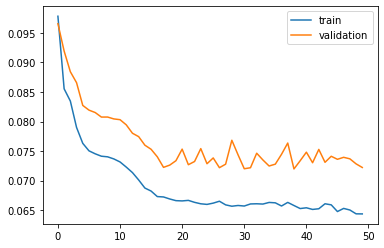

Training LSTM:  16017.699204921722
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  16146.910560846329
End of fold 0: 16146.92253947258
Fold:  2
Epoch 1/50
 - 342s - loss: 0.0963 - val_loss: 0.0913

Epoch 00001: val_loss improved from inf to 0.09132, saving model to weights1.hdf5
Epoch 2/50
 - 319s - loss: 0.0852 - val_loss: 0.0849

Epoch 00002: val_loss improved from 0.09132 to 0.08489, saving model to weights1.hdf5
Epoch 3/50
 - 319s - loss: 0.0828 - val_loss: 0.0839

Epoch 00003: val_loss improved from 0.08489 to 0.08393, saving model to weights1.hdf5
Epoch 4/50
 - 334s - loss: 0.0778 - val_loss: 0.0762

Epoch 00004: val_loss improved from 0.08393 to 0.07615, saving model to weights1.hdf5
Epoch 5/50
 - 325s - loss: 0.0751 - val_loss: 0.0740

Epoch 00005: val_loss improved from 0.07615 to 0.07397, saving model to weights1.hdf5
Epoch 6/50
 - 321s - loss: 0.0743 - val_loss: 0.0736

Epoch 00006: val_loss improved from 0.07397 to 0.07358, saving model to weights1.hdf5
Epoc

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f123f688240>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f123f69ce80>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

 - 321s - loss: 0.0710 - val_loss: 0.0718

Epoch 00010: val_loss improved from 0.07270 to 0.07178, saving model to weights1.hdf5
Epoch 11/50
 - 323s - loss: 0.0695 - val_loss: 0.0697

Epoch 00011: val_loss improved from 0.07178 to 0.06972, saving model to weights1.hdf5
Epoch 12/50
 - 319s - loss: 0.0685 - val_loss: 0.0690

Epoch 00012: val_loss improved from 0.06972 to 0.06902, saving model to weights1.hdf5
Epoch 13/50
 - 321s - loss: 0.0673 - val_loss: 0.0679

Epoch 00013: val_loss improved from 0.06902 to 0.06792, saving model to weights1.hdf5
Epoch 14/50
 - 322s - loss: 0.0667 - val_loss: 0.0686

Epoch 00014: val_loss did not improve from 0.06792
Epoch 15/50
 - 321s - loss: 0.0664 - val_loss: 0.0676

Epoch 00015: val_loss improved from 0.06792 to 0.06758, saving model to weights1.hdf5
Epoch 16/50
 - 319s - loss: 0.0656 - val_loss: 0.0664

Epoch 00016: val_loss improved from 0.06758 to 0.06642, saving model to weights1.hdf5
Epoch 17/50
 - 318s - loss: 0.0651 - val_loss: 0.0665

Epoch

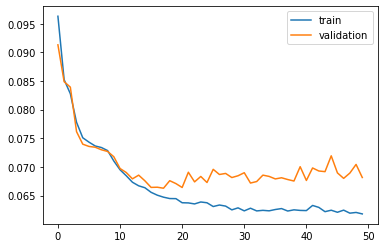

Training LSTM:  16076.100574731827
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  16204.659101247787
End of fold 1: 16204.672900915146
rmse_lstm_list
[0.9876091810174584, 0.875692199999267]
Entire process took: 32351.745770692825


In [351]:
import tensorflow as tf
###########################################
# two fold cross validatioin
###########################################

# keras generators need to be 
# infinitely iterable
def train_generator(x_list, y_list):
    # 0.1 validatioin split
    train_length = (len(x_list)//10)*9
    while True:
        for i in range(train_length):
            train_x = np.array([x_list[i]])
            train_y = np.array([y_list[i]])
            yield train_x, train_y
            
def val_generator(x_list, y_list):
#    # 0.1 validation split
    val_length = len(x_list)//10
    while True:
        for i in range(-val_length, 0, 1):
            val_x = np.array([x_list[i]])
            val_y = np.array([y_list[i]])
            yield val_x, val_y
            
###########################################
# use keras.utils.Sequence for 
# thread-safe multiprocess
###########################################
start_idx = 0
size = len(len_list_train)//2 #changed from 10

rmse_lstm_list = []
rmse_naive_list = []

complete_inv_y = np.empty([0, 32])
complete_inv_yhat = np.empty([0, 32])
complete_inv_naive = np.empty([0, 32])

start_outside = time.time()

for f in range(2):  #2
    print("Fold: ", f+1)
    ##################################
    # forecast using LSTM
    ##################################
    lstm_start = len_list_x_train[f]
    lstm_end = len_list_x_train[f+1]
    

    train1_x = x_train_list[:lstm_start]
    train2_x = x_train_list[lstm_end:]
    train_x = train1_x + train2_x
    
    test_x = x_test_list[lstm_start:lstm_end]
    
    train1_y = y_train_list[:lstm_start]
    train2_y = y_train_list[lstm_end:]
    train_y = train1_y + train2_y
    
    test_y = y_test_list[lstm_start:lstm_end]
    
    # time training
    start_time = time.time()
    # design network
    #with tf.device('/device:GPU:0'):
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):        
        model = Sequential()
        model.add(CuDNNLSTM(256, return_sequences=True,
                        input_shape=(None, 32)))
        model.add(CuDNNLSTM(256, return_sequences=True))
        model.add(CuDNNLSTM(256))
        model.add(Dense(9))
        model.compile(loss='mae', optimizer='adam')
        weight = "weights" + str(f) + ".hdf5"
        checkpointer = ModelCheckpoint(filepath=weight,
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True)
        history = model.fit_generator(generator=train_generator(train_x, 
                                                                train_y), 
                                        steps_per_epoch=(len(train_x)//10)*9, 
                                        epochs=50, 
                                        validation_data=val_generator(train_x, 
                                                                    train_y), 
                                        validation_steps=len(train_x)//10, 
                                        callbacks=[checkpointer], 
                                        verbose=2, shuffle=False)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    end_time = time.time()
    print("Training LSTM: ", end_time - start_time)
    #########################################
    # LSTM prediction
    #########################################
    model.load_weights(weight)
    yhat = np.empty((0, 9))
    forecast = np.empty((0, 9))
    for i in range(len(test_x)):
        #yhat_pred = model.predict(np.array([test_x[i]]))
        #print("yhat_pred.shape: ", yhat_pred.shape)
        #yhat = np.append(yhat, yhat_pred, axis=0)
        if len(test_x[i]) < 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
        elif len(test_x[i]) == 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
            #print("forecast shape", forecast.shape)
            #print("yhat_pred shape", yhat_pred.shape)
            forecast = np.append(forecast, yhat_pred, axis=0)
        elif len(test_x[i]) > 8:
            adjusted_y = np.append(test_x[i][:-len(forecast), -9:], forecast, axis=0)
            test_x[i] = np.append(test_x[i][:, :-9], adjusted_y, axis=1)
            yhat_pred = model.predict(np.array([test_x[i]]))
            #print("forecast shape", forecast.shape)
            #print("yhat_pred shape", yhat_pred.shape)
            forecast = np.append(forecast, yhat_pred, axis=0)    
            if len(test_x[i]) == 27:
                forecast = np.empty((0, 9))
        #print("yhat shape", yhat.shape)
        #print("yhat_pred shape", yhat_pred.shape)
        yhat = np.append(yhat, yhat_pred, axis=0)
    start = len_list_train[start_idx]
    end = len_list_train[start_idx+size]
    #print("x_train[start:end, :-9] shape", x_train[start:end, :-9].shape)
    #print("yhat shape", yhat.shape)
    xyhat = np.append(x_train[start:end, :-9], yhat, axis=1)
    inv_yhat = scaler.inverse_transform(xyhat)
    inv_y = scaler.inverse_transform(ground_truth_train[start:end, :])
    if np.array_equal(inv_y[:, :-9], inv_yhat[:, :-9]):
        print("inv_y x and inv_yhat x are the same")
    else:
        print("inv_y x and inv_yhat x are not the same")
    end_time = time.time()
    print("Training and Testing LSTM: ", end_time - start_time)
    #########################################################
    # forecasting using Vector Autoregression (VAR) and Naive
    #########################################################
    rmse_lstm = math.sqrt(mean_squared_error(inv_y[:, -9:], inv_yhat[:, -9:]))
    rmse_lstm_list.append(rmse_lstm)
    
    complete_inv_y = np.append(complete_inv_y, inv_y, axis=0)
    complete_inv_yhat = np.append(complete_inv_yhat, inv_yhat, axis=0)

    end_time = time.time()
    print("End of fold "+str(f)+":", end_time - start_time)
    start_idx += size
print("rmse_lstm_list")
print(rmse_lstm_list)
end_outside = time.time()
print("Entire process took:", end_outside - start_outside)

In [353]:
complete_inv_y_df = pd.DataFrame(complete_inv_y)
complete_inv_y_df.columns = ['STUDENT_INDEX_MASTER', 'QUARTERS',
                             'AGE', 'SEX', 'NZDEP', 'ETHN_A', 
                             'ETHN_B', 'ETHN_C', 'ETHN_D', 
                             'ETHN_E', 'ETHN_H',# (10)
                             'SBP', 'DBP', 'SBP2', 'DBP2',
                             'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
                             'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
                             'RENAL', 'HX_DIABETES_YR', 'STATINS',
                             'ATORVASTATIN', 'SIMVASTATIN', 
                             'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 
                             'TCHDL']
complete_inv_y_df.to_csv('/home/whsu014/data/LSTM_experiment_normalised_train2500inds_ID_y.csv', sep=",")
complete_inv_yhat_df = pd.DataFrame(complete_inv_yhat)
complete_inv_yhat_df.columns = ['STUDENT_INDEX_MASTER', 'QUARTERS',
                             'AGE', 'SEX', 'NZDEP', 'ETHN_A', 
                             'ETHN_B', 'ETHN_C', 'ETHN_D', 
                             'ETHN_E', 'ETHN_H',# (10)
                             'SBP', 'DBP', 'SBP2', 'DBP2',
                             'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
                             'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
                             'RENAL', 'HX_DIABETES_YR', 'STATINS',
                             'ATORVASTATIN', 'SIMVASTATIN', 
                             'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 
                             'TCHDL']
complete_inv_yhat_df.to_csv('/home/whsu014/data/LSTM_experiment_normalised_train2500inds_ID_yhat.csv', sep=",")


In [66]:
complete_inv_y1_df = pd.read_csv('/home/whsu014/data/LSTM_experiment_train2500inds_y.csv')
complete_inv_yhat1_df = pd.read_csv('/home/whsu014/data/LSTM_experiment_train2500inds_yhat.csv')
print(complete_inv_y1_df.columns)
print(complete_inv_y1_df.shape)
complete_inv_y = complete_inv_y1_df.values[:, 1:]
complete_inv_yhat = complete_inv_yhat1_df.values[:, 1:]
print(complete_inv_y.shape)
print(complete_inv_yhat.shape)

Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'QUARTERS', 'AGE', 'SEX', 'NZDEP',
       'ETHN_A', 'ETHN_B', 'ETHN_C', 'ETHN_D', 'ETHN_E', 'ETHN_H', 'SBP',
       'DBP', 'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
       'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR',
       'STATINS', 'ATORVASTATIN', 'SIMVASTATIN', 'TEST', 'HDL', 'LDL', 'TRI',
       'TCL', 'TCHDL'],
      dtype='object')
(135000, 33)
(135000, 32)
(135000, 32)


In [352]:
#########################################
# map number id back to unique strings
#########################################
print(complete_inv_y.shape)
print(complete_inv_yhat.shape)
print(complete_inv_y[0:20, 0])

num_to_ID = {v: k for k, v in ID_to_num.items()}
complete_inv_y = np.array(complete_inv_y, dtype = np.object)
complete_inv_yhat = np.array(complete_inv_yhat, dtype = np.object)

for i in range(len(complete_inv_y)):
    complete_inv_y[i, 0] = num_to_ID[round(complete_inv_y[i, 0])]
    complete_inv_yhat[i, 0] = num_to_ID[round(complete_inv_yhat[i, 0])]
print(complete_inv_y[0:20, 0])
print(complete_inv_yhat[0:20, 0]) 
######################################
# inverse log transform cholesterol values
######################################
#complete_inv_y[:, -5:] = np.exp(complete_inv_y[:, -5:].astype(np.double))
#complete_inv_yhat[:, -5:] = np.exp(complete_inv_yhat[:, -5:].astype(np.double))

(135000, 32)
(135000, 32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz']
['STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz']


In [69]:
print(VIEW_df.columns)
VIEW_v = VIEW_df.values[:, 1:]

Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')


In [296]:
print(len(np.unique(complete_inv_y[:, 0])))
print(len(np.unique(complete_inv_yhat[:, 0])))
# Columns of VIEW_ground_truth_v
# STUDENT_INDEX_MASTER, QUARTERS, 
# STATINS, ATORVASTATIN, SIMVASTATIN,
# TEST, HDL, LDL, TRI, TCL, TCHDL,
# TRUE_HDL, TRUE_LDL, TRUE_TRI, TRUE_TCL, TRUE_TCHDL
VIEW_ground_truth_v = VIEW_df.iloc[:, [1,3,4,14,15,16,8,9,10,11,12,13,34,35,36,37,38]].values
print(VIEW_ground_truth_v.shape)

5000
5000
(2099160, 17)


In [344]:
id_list = np.unique(complete_inv_y[:, 0])
start_t = time.time()
for i in range(1):
    #ind_y = complete_inv_y[(i*27):((i+1)*27), ]
    #ind_yhat = complete_inv_yhat[(i*27):((i+1)*27), ]
    #ind_id = ind_y[0,0]
    #ind_view = VIEW_sub_v[VIEW_sub_v[:, 0] == ind_id]
    ind_id = id_list[i]
    ind_y = complete_inv_y[complete_inv_y[:, 0] == ind_id]
    ind_yhat = complete_inv_yhat[complete_inv_yhat[:, 0] == ind_id]
    ind_view = VIEW_ground_truth_v[VIEW_ground_truth_v[:, 0] == ind_id]
    print(ind_y.shape)
    print(ind_yhat.shape)
    print(ind_view.shape)
    print(np.around(ind_yhat[:, -9:].astype(np.double), decimals=2))
    print(np.around(ind_y[:, -9:].astype(np.double), decimals=2))
    #print(np.around(ind_yhat[:, -9:].astype(np.double), decimals=2))
    print(np.around(ind_view[:, [6,7,8,9,10,11]].astype(np.double), decimals=2))
end_t = time.time()
print(end_t-start_t)

(27, 32)
(27, 32)
(28, 17)
[[ 0.    0.   -0.    0.    1.29  4.54  2.38  6.91  5.44]
 [-0.    0.   -0.    0.    1.33  4.03  2.3   6.38  4.87]
 [ 0.78 -0.    0.77 -0.    1.3   3.17  1.8   5.33  4.06]
 [ 0.98  0.99 -0.02 -0.01  1.3   2.96  1.88  5.05  3.98]
 [ 0.98  0.99 -0.01 -0.01  1.26  3.44  2.15  5.64  4.51]
 [ 0.99  0.99 -0.   -0.01  1.21  3.47  2.37  5.75  4.78]
 [ 0.99  0.99 -0.   -0.01  1.3   3.58  2.23  5.89  4.53]
 [ 0.99  0.99 -0.01 -0.01  1.27  3.61  2.4   6.01  4.73]
 [ 0.99  0.99 -0.01 -0.01  1.29  3.68  2.14  5.97  4.62]
 [ 0.99  0.99 -0.01 -0.01  1.31  3.66  1.79  5.75  4.39]
 [ 0.99  0.99 -0.   -0.01  1.3   3.64  1.61  5.6   4.29]
 [ 0.99  0.99 -0.   -0.01  1.32  3.59  1.53  5.5   4.18]
 [ 0.99  0.99 -0.   -0.01  1.33  3.5   1.45  5.38  4.05]
 [ 0.99  0.99 -0.   -0.01  1.33  3.43  1.43  5.3   3.99]
 [ 0.99  0.99 -0.   -0.01  1.33  3.4   1.42  5.27  3.95]
 [ 0.99  0.99 -0.   -0.01  1.33  3.38  1.42  5.24  3.93]
 [ 0.99  0.99 -0.   -0.01  1.33  3.35  1.43  5.21  3.92]
 [ 0

In [305]:
value_indicating_test = max(np.unique(VIEW_ground_truth_v[:, 6]))
value_indicating_no_test = min(np.unique(VIEW_ground_truth_v[:, 6]))
print(value_indicating_test)
print(value_indicating_no_test)
print(VIEW_ground_truth_v[0,0])
print(complete_inv_y[0,0])
ind_id = complete_inv_y[0, 0]
print(VIEW_ground_truth_v[VIEW_ground_truth_v[:, 0]==ind_id].shape)
deepcopy = copy.deepcopy(VIEW_ground_truth_v[VIEW_ground_truth_v[:, 0]==ind_id])
print(deepcopy.shape)

1
0
STb77b2NPhNK
STGeicKXNtxz
(28, 17)
(28, 17)


In [312]:
# Columns of VIEW_ground_truth_v
# STUDENT_INDEX_MASTER, QUARTERS, AGE,
# STATINS, ATORVASTATIN, SIMVASTATIN,
# TEST, HDL, LDL, TRI, TCL, TCHDL,
# TRUE_HDL, TRUE_LDL, TRUE_TRI, TRUE_TCL, TRUE_TCHDL
#########################
# create naive forecast
#########################
value_indicating_test = max(np.unique(VIEW_ground_truth_v[:, 6]))
value_indicating_no_test = min(np.unique(VIEW_ground_truth_v[:, 6]))

naive_v = np.empty([0, 17])
for i in range(len(complete_inv_y)//27): #number_of_inds  len(complete_inv_y)//27
    ind_id = complete_inv_y[(i*27), 0]
    ind_v = copy.deepcopy(VIEW_ground_truth_v[VIEW_ground_truth_v[:, 0]==ind_id])
    #print("ind_v shape", ind_v.shape)
    #ind_v = copy.deepcopy(VIEW_1hot_encoded_v[(i*28):((i+1)*28), :])
    test_list = list(ind_v[0:8, 6])
    quarters_v = copy.deepcopy(ind_v[:, 1])
    age_v = copy.deepcopy(ind_v[:, 2])
    idx = len(test_list) - 1 - \
          test_list[::-1].index(value_indicating_test)
    last_v = copy.deepcopy(ind_v[idx, -11:])
    # parse values from TRUE choleterol lists\
    for j in range(1, 6):
        ch_s = last_v[j+5]
        if len(ch_s) > 4:
            ch_list = ch_s[1:-1].split(', ')
            last_v[j] = float(ch_list[-1])
        else:
            missing_a_measure += 1
            IDs_of_missing_measure.append(ind_v[0, 0])
    ind_v[idx, -11:] = last_v
    last_v[0] = value_indicating_no_test #this might be the wrong assumption
    for j in range((idx+1),28):
        ind_v[j, -11:] = last_v
    ind_v[:, 1] = quarters_v
    ind_v[:, 2] = age_v
    naive_v = np.append(naive_v, ind_v[1:,:], axis = 0)
print("complete_inv_y shape", complete_inv_y.shape)
print("complete_inv_yhat shape", complete_inv_yhat.shape)
print("naive shape", naive_v.shape)

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (28, 17)
ind_v shape (

NameError: name 'naive' is not defined

In [320]:
# check to see if data y, yhat and naive are equal
print(np.array_equal(complete_inv_y[:, 0], complete_inv_yhat[:, 0]))
print(np.array_equal(complete_inv_y[:, 0], naive_v[:, 0]))
#####################
# error calculation
#####################
y_error = []
LSTM_error = []
naive_error = []
for i in range(1):#len(complete_inv_y)//27
    ind_id = complete_inv_y[i*27, 0]
    ind_y = copy.deepcopy(complete_inv_y[(i*27):((i+1)*27), :])
    ind_yhat = copy.deepcopy(complete_inv_yhat[(i*27):((i+1)*27), :])
    ind_naive = copy.deepcopy(naive_v[(i*27):((i+1)*27), :])
    ind_truth = copy.deepcopy(VIEW_ground_truth_v[VIEW_ground_truth_v[:, 0]==ind_id])
    ind_truth = ind_truth[1:, :]
    print(ind_y.shape)
    print(ind_yhat.shape)
    print(ind_naive.shape)
    print(ind_truth.shape)
    for i in range(7, 27)

True
True
(27, 32)
(27, 32)
(27, 17)
(27, 17)


In [311]:
print(np.around(complete_inv_y[0:27, -9:].astype(np.double), decimals=2))
print(np.around(complete_inv_yhat[0:27, -9:].astype(np.double), decimals=2))
#print(np.around(VIEW_ground_truth_v[0:28, [2,3,4,5,6,7]].astype(np.double), decimals=2)) 
print(np.around(naive_v[:, -14:-5].astype(np.double), decimals=2))

[[0.   0.   0.   0.   1.52 3.88 2.31 6.52 4.31]
 [0.   0.   0.   1.   1.5  3.5  2.13 6.03 4.04]
 [0.   0.   0.   0.   1.5  2.98 1.84 5.38 3.58]
 [1.   0.   1.   0.   1.5  2.46 1.55 4.73 3.13]
 [1.   0.   1.   1.   1.48 2.41 1.48 4.61 3.1 ]
 [0.   0.   0.   0.   1.45 2.84 1.65 5.04 3.49]
 [0.   0.   0.   0.   1.42 3.26 1.81 5.46 3.88]
 [0.   0.   0.   1.   1.19 3.26 1.5  5.09 4.34]
 [0.   0.   0.   1.   0.95 2.99 0.93 4.37 4.62]
 [0.   0.   0.   0.   1.14 3.26 1.04 4.88 4.38]
 [0.   0.   0.   0.   1.33 3.53 1.14 5.39 4.14]
 [0.   0.   0.   1.   1.43 3.74 1.4  5.82 4.11]
 [0.   0.   0.   0.   1.41 3.84 1.91 6.13 4.39]
 [0.   0.   0.   0.   1.39 3.95 2.43 6.44 4.67]
 [0.   0.   0.   0.   1.37 4.05 2.94 6.74 4.96]
 [0.   0.   0.   1.   1.36 4.1  3.14 6.87 5.09]
 [0.   0.   0.   0.   1.35 4.11 3.02 6.82 5.08]
 [0.   0.   0.   0.   1.34 4.12 2.89 6.76 5.06]
 [0.   0.   0.   0.   1.34 4.13 2.77 6.71 5.05]
 [0.   0.   0.   0.   1.33 4.13 2.64 6.66 5.03]
 [0.   0.   0.   0.   1.32 4.14 2.52 6.6

In [291]:
print(VIEW_1hot_encoded_test_v[0:28, :-5])

[[0 0 59.0 0 1 1.0 0.0 0.0 0.0 0.0 0.0 140.0 80.0 130 80.0 0.0 4.1 0.0
  0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 1.5779456193353474 4.072809667673717
  2.3389728096676734 6.789728096676737 4.338972809667673]
 [0 1 60.0 0 1 1.0 0.0 0.0 0.0 0.0 0.0 140.0 80.0 130 80.0 0.0 4.1 0.0
  0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 1.5235649546827794 3.882477341389728
  2.311782477341389 6.517824773413897 4.3117824773413895]
 [0 2 60.0 0 1 1.0 0.0 0.0 0.0 0.0 0.0 140.0 80.0 130 80.0 0.0 4.1 0.0
  0.0 0.0 0.0 0 0 0.0 0.0 0.0 1 1.5 3.5043478260869563 2.133695652173913
  6.0304347826086975 4.041304347826086]
 [0 3 60.0 0 1 1.0 0.0 0.0 0.0 0.0 0.0 140.0 80.0 130 80.0 0.0 4.1 0.0
  0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 1.5 2.9826086956521736 1.840217391304348
  5.378260869565216 3.584782608695652]
 [0 4 60.0 0 1 1.0 0.0 0.0 0.0 0.0 0.0 140.0 80.0 130 80.0 0.0 4.1 0.0
  0.0 0.0 0.0 0 0 1.0 0.0 1.0 0 1.5 2.460869565217392 1.5467391304347826
  4.72608695652174 3.1282608695652168]
 [0 5 61.0 0 1 1.0 0.0 0.0 0.0 0.0 0.0 140.0 80.0 130 